# ghg_analytics
## Insights into trends with global greenhouse gases and climate change action.

EPA1333 – Computer Engineering for Scientific Computing Final Project

### Authors
Group 6:
* Aashna Mittal
* Gamze Ünlü
* Jason R Wang

In [1]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import NaN
plt.style.use('ggplot')

## Data Cleaning

### For Current Greenhouse Gas Emissions
Source: https://data.worldbank.org/indicator/EN.ATM.GHGT.KT.CE?view=chart
(Is this true, Aashna?) - Jason

In [2]:
#Import data on Greenhouse Gases
GreenhouseGasesOriginalDf = pd.read_csv("Data Sources/GreenhouseGasData.csv", sep=',', skipinitialspace=True, skiprows=4) 
#print("Original dataframe...\n", GreenhouseGasesOriginalDf.head(10))

#Drop the indicator name and indicator code as the values are same across the whole dataframe
GreenhouseGasesDf = GreenhouseGasesOriginalDf.drop(["Indicator Code", "Indicator Name"], axis = 1)

#Drop all the columns that contain only null values
GreenhouseGasesDf.dropna(axis = 1, how="all", inplace=True)  

#Drop all the rows that contain only null values, starting from column 2
GreenhouseGasesDf.dropna(axis = 0, how="all", subset = GreenhouseGasesDf.columns[2:], inplace= True)  

#First interpolate missing values and then use backfill to fill starting NA values of a row
GreenhouseGasesDf.iloc[:,2:] = GreenhouseGasesDf.iloc[:,2:].interpolate(axis = 1).bfill(axis=1)

GreenhouseGasesDf.head()

,Country Name,Country Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,Aruba,ABW,42.306298,42.786948,43.286613,43.724590,44.130957,44.481908,131.633746,135.055319,...,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02,6.169287e+02
1,Afghanistan,AFG,14306.616300,14391.778200,13040.848000,13535.754100,14945.968200,14574.164000,14746.851000,15247.281000,...,1.470988e+04,1.465437e+04,1.477026e+04,1.484916e+04,1.527263e+04,1.528878e+04,1.555443e+04,1.779133e+04,1.798131e+04,1.816886e+04
2,Angola,AGO,60648.601080,39162.171430,42205.650700,44252.669120,40179.233500,44429.300030,38448.024090,43563.412180,...,3.585801e+04,3.686023e+04,3.585574e+04,3.637582e+04,3.669053e+04,3.739629e+04,3.830947e+04,4.002939e+04,4.087865e+04,4.165716e+04
3,Albania,ALB,6960.868200,6950.036100,7613.266100,7348.492100,7632.664300,7873.037000,8470.978400,8948.980900,...,7.834016e+03,7.401102e+03,8.308386e+03,8.027150e+03,9.879394e+03,8.136785e+03,8.108812e+03,8.506996e+03,8.712296e+03,8.898641e+03
5,Arab World,ARB,552362.062026,576946.152269,625015.943839,699280.217253,679448.005841,683966.235399,775863.729505,799971.040800,...,1.963193e+06,1.660587e+06,1.767879e+06,1.731289e+06,2.355481e+06,2.364089e+06,2.387502e+06,1.924245e+06,2.483349e+06,1.908696e+06


### Create Comparison for Country Group Codes and Names

In [3]:
#Import the dataframe which contains the codes of country group aggregates
CountryGroupCodes = pd.read_excel("Data sources/CountryGroups.xls", sheet = "Groups", skiprows=226, header = None)
CountryGroupCodes.dropna(how="all", inplace=True, axis=1)
CountryGroupCodes.drop(columns=0,inplace=True)
CountryGroupCodes.dropna(how="all", inplace=True, axis=0)
CountryGroupCodes.columns = ["Aggregate Name", "Aggregate Code"]
CountryGroupCodes

#Drop the rows corresponding to aggregate country codes from existing dataframe to create a new country dataframe 
GreenhouseGasesCountryDf = GreenhouseGasesDf[GreenhouseGasesDf["Country Code"].apply(lambda x: False if x in CountryGroupCodes["Aggregate Code"].values else True)]

## Data visualization

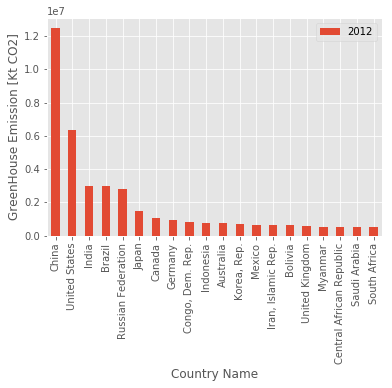

In [4]:
#Sorted bar chart of 2012 greenhouse gases

GreenhouseGasesCountryDf.sort_values(by="2012", ascending=False)[["Country Name", "2012"]]

GreenhouseGasesTop20Emitters = GreenhouseGasesCountryDf.sort_values(by = "2012", ascending = False).iloc[:20,:]

GreenhouseGasesTop20Emitters[["Country Name", "2012"]].plot(x = "Country Name", kind="bar")

plt.ylabel("GreenHouse Emission [Kt CO2]")
plt.show()

### NDCs

This file gives data in the format: ISO Country Code,Country Name, Goal Year, Value (in MtCO2e), if goal is a range, and the type of goal.

In [5]:
NDCsDf_raw = pd.read_csv('data/wri/CW_NDC_quantification_April30.csv')
NDCsDf = NDCsDf_raw.dropna(axis=0).drop(328) #328 is a mis-entry, as determined through inspection

In [6]:
# Check data input
NDCsDf.head(5)

,ISO,Country,Year,Value,Range,Label
0,AFG,Afghanistan,2020,35.5,No,BAU
1,AFG,Afghanistan,2025,40.3,No,Conditional
2,AFG,Afghanistan,2025,41.7,No,BAU
3,AFG,Afghanistan,2030,42.7,No,Conditional
4,AFG,Afghanistan,2030,48.9,No,BAU


Some countries' NDCs are given as a range. For simplicity, this analysis will only examine the mean of that range.

In [7]:
rangedIndices = NDCsDf[NDCsDf['Range'] == 'Yes'].index

# Note that each range is a pair
# Is there a non-for loop method to do this?
for i in range(0,len(rangedIndices)-1,2):    
    NDCsDf.loc[rangedIndices[i],'Value'] = (
        (NDCsDf['Value'][rangedIndices[i]] + NDCsDf['Value'][rangedIndices[i+1]])/2
    )
    
# Drop the column 'Range', since it is not really needed anymore.
NDCsDf = NDCsDf.drop(labels=rangedIndices[1::2], axis=0).drop(labels='Range', axis=1)

From here on, the situation in 2030 will be the primary focus. Where countries have not submitted data for 2030, the furthest value is used. Furthermore, the best case where the higher goal between choices (e.g. uncondintional if both it and conditional exist) is taken.

Note that the EU, which is collectively a large emitter, has only submitted NDCs for 2020.

In [8]:
NDC_byCountry = []

for i in NDCsDf['ISO'].unique():
    NDC_byCountry.append(NDCsDf[NDCsDf['ISO']==i]['Value'].min() )

In [9]:
d = {
    'Country': NDCsDf['ISO'].unique(),
    'Goal':    NDC_byCountry 
}

NDCs_clean = pd.DataFrame(d)

In [11]:
NDCs_clean.head()

,Country,Goal
0,AFG,35.5000
1,ALB,5.4500
2,AND,0.3299
3,AGO,96.6300
4,ATG,0.2910
